# Room temperature Langevin fitting 

Jupyter notebook for Room temperature langevin fitting using a size distribution obtained from SAXS

In [18]:
# imports
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.integrate import quad

# constants
# Bohr magneton in J/T
uB = 9.2740100783e-24
# Boltzmann constant in J/K
kB = 1.380649e-23

## Load Data

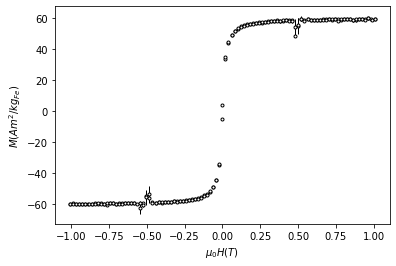

In [7]:
# load data
x,y,ey = np.loadtxt("Hysteresis_OC15_P_B3a_300K.dat", usecols=(2,4,5), unpack=True, delimiter=",", skiprows=31)

# subtract background
y +=2.255e-8*x

# convert x into Tesla
x /= 10000

# normalize to iron content from ICP-OES
y /= 1.363e-6
ey /= 1.363e-6

#normalize data to amount of iron present in iron oxide mixture, i.e. 70%
y *= 0.7
ey *= 0.7

# plot data
fig,ax = plt.subplots()
ax.errorbar(x,y,ey,linewidth=0, marker='.',markerfacecolor=(1,1,1), color=(0,0,0), ecolor=(0,0,0), elinewidth=1)
ax.set_ylabel("$M (Am^2/kg_{Fe})$")
ax.set_xlabel("$\mu_0H (T)$"); # semicolon suppresses return statement of pyplot

## Lognormal size distribution

The lognormal size distribution is defined as:
$D_N(R,R0,S)=\frac{1}{(2\pi)^{1/2}SR}\exp\left[-\frac{\ln^2(R/R_0)}{2S^2}\right]$

In [8]:
# function for lognormal size distribution
def lognorm(r,s,r0):
    y = -(np.log(r/r0)**2)/(2*s**2)
    pdf = 1/(np.sqrt(2*np.pi)*s*r)*np.exp(y)
    return pdf

Integral: 1.000000


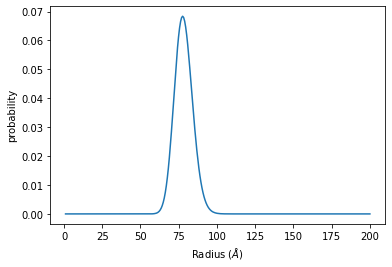

In [9]:
r_range = np.linspace(1,200,300)
plt.plot(r_range, lognorm(r_range,0.075,78))
plt.xlabel("Radius ($\AA$)")
plt.ylabel("probability")
integral = quad(lognorm,40,125, args=(0.075,78))
print("Integral: %2f" % integral[0])

## Langevin fit with size distribution

The field dependent magnetization M(H) at room temperature for non-interacting nanoparticles with a lognormal size distribution is described by:

$M(B,T) = \int_{0}^{\infty}M_{sat} L\left(\frac{\mu_p B}{k_B T}\right)P(v)dv$, 

where $P(v)$ is the size distribution as given above and $L(x)$ is the Langevin function according to $L(x) = \coth(x)-1/x = 1/\tanh(x)-1/x$. $\mu_p$ is the particle magentic moment, $k_B$ is the Boltzmann constant and $T$ is the temperature in Kelvin. $M_{sat}$ relates to the particle magnetic moment via $M_{sat}=\mu_p/(V_{total}\rho)$, therefore the equation for M can be rewritten to 

$M(B,T) = \int_{0}^{\infty}\frac{\mu_p}{V_{total}\rho} L\left(\frac{\mu_p B}{k_B T}\right)P(v)dv$

Note that in the case below the size distribution has only a very small effect on the shape of the curve since the used sample was quite monodisperse.

In [16]:
# Langevin function
def langevin(x,R,Ms):
    # R in angstrom, density in kg/m^3
    density = 4.95e3
    V = 4/3*np.pi*(R*1e-10)**3
    up = V * Ms * density
    return Ms*(1/np.tanh(up*x/(kB*300))-1/(up*x/(kB*300)))

def integrand(r,x,r0,s,ms):
    return lognorm(r,s,r0)*langevin(x,r,ms)
    
def integral_sizedist(x,r0,s,ms):
    M = np.zeros_like(x)
    for i in range(len(x)):
        M[i] += quad(integrand, 40, 120, args=(x[i],r0,s,ms))[0]
    return M

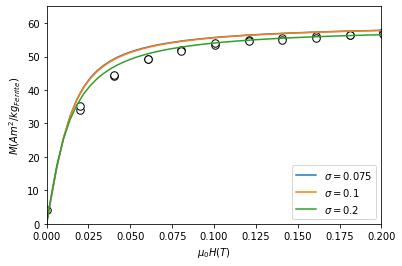

In [17]:
fig,ax = plt.subplots()
ax.set_ylabel("$M (Am^2/kg_{Ferrite})$")
ax.set_xlabel("$\mu_0H (T)$")
ax.set_xlim(0,0.2)
ax.set_ylim(0,65)

#data
ax.errorbar(x,y,ey,linewidth=0, 
            marker='.',
            markerfacecolor=(1,1,1), 
            color=(0,0,0), 
            ecolor=(0,0,0), 
            elinewidth=1,
            markersize=15)

#calculated with size distribution, using different values for the sigma parameter
x_calc = np.linspace(-1,1,500)
R = 78
Ms = 60
ax.errorbar(x_calc,integral_sizedist(x_calc,R,0.075,Ms), label=r"$\sigma = 0.075$")
ax.errorbar(x_calc,integral_sizedist(x_calc,R,0.1,Ms), label=r"$\sigma = 0.1$")
ax.errorbar(x_calc,integral_sizedist(x_calc,R,0.2,Ms), label=r"$\sigma = 0.2$")
ax.legend();